In [89]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from __future__ import print_function
import keras
from keras import utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import roc_curve, roc_auc_score

In [42]:
# Constants

#paths
ROOT_IMG = '../input/biopsy_images/'
DATASET = "../output/new_subset6000.csv"
ROOT_MODELS = 'Models/'

#img size
IMG_ROWS = 224
IMG_COLS = 224
IMG_COLORS = 3

#Num images to use
#202599
IMG_NUM=6000

# Train-Test distribution
TRAIN_RATIO=0.2
#RANDOM_STATE=42

# fit parameters
BATCH_SIZE = 40
EPOCHS = 100

In [43]:
# Shape ofe the images
input_shape = ( IMG_ROWS, IMG_COLS, IMG_COLORS)
# Number of labels
num_classes = 2

In [44]:
"""
#NN topology
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
"""

"\n#NN topology\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3),\n                 activation='relu',\n                 input_shape=input_shape))\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(num_classes, activation='sigmoid'))\n\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n"

In [45]:
#NN topology
model = Sequential()

chanDim = -1
if K.image_data_format() == "channels_first":
    chanDim = 1
    
model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [46]:
df=pd.read_csv(DATASET)
df=df[0:IMG_NUM]
#df=df[COLUMNS]
#df=df.replace(-1,0)

In [47]:
df["label"] = df["label"].replace("MSI",0)
df["label"] = df["label"].replace("MSS",1)
df["label"]

0       0
1       0
2       0
3       0
4       0
       ..
5995    1
5996    1
5997    1
5998    1
5999    1
Name: label, Length: 6000, dtype: int64

In [48]:
df["label"].value_counts()

1    3000
0    3000
Name: label, dtype: int64

In [49]:
#y

In [50]:
#y[0]

In [51]:
"""
X_train, X_test, y_train, y_test = train_test_split(
                df.image_id, df.drop(columns=['image_id']), test_size=TRAIN_RATIO, random_state=RANDOM_STATE)
"""
X_train, X_test, y_train, y_test = train_test_split(df.image, df.label, test_size=TRAIN_RATIO)

In [52]:
# generator to feed the fit
def generator(data,target,bs,rootImg,mode='train'):
    images=[]
    labels=[]
    count=0
    while True:
        images.append(cv2.imread(rootImg+data.iloc[count]))
        if target.iloc[count] == 1:
            labels.append([0,1])
        else:
            labels.append([1,0])
        count+=1
        if len(labels)==bs:
            images=np.array(images)
            labels=np.array(labels)
            if mode == "eval":
              yield images
            else:
              yield images, labels
            images=[]
            labels=[]
        if count==data.shape[0]:
            if mode == "eval":
                break
            else:
                count=0

In [53]:
# Save the model at the end of every epoch if val_accuracy is better 
filepath='Checkpoint_{epoch:02d}_{val_accuracy:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [54]:
"""
# Ask keras which format to use depending on used backend and arrange data as expected
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], IMG_COLORS, IMG_ROWS, IMG_COLS)
    X_test = X_test.reshape(X_test.shape[0], IMG_COLORS, IMG_ROWS, IMG_COLS)
    input_shape = (IMG_COLORS, IMG_ROWS, IMG_COLS)
else:
    X_train = X_train.reshape(X_train.shape[0], IMG_ROWS, IMG_COLS, IMG_COLORS)
    X_test = X_test.reshape(X_test.shape[0], IMG_ROWS, IMG_COLS, IMG_COLORS)
    input_shape = (IMG_ROWS, IMG_COLS, IMG_COLORS)

# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
"""

"\n# Ask keras which format to use depending on used backend and arrange data as expected\nif K.image_data_format() == 'channels_first':\n    X_train = X_train.reshape(X_train.shape[0], IMG_COLORS, IMG_ROWS, IMG_COLS)\n    X_test = X_test.reshape(X_test.shape[0], IMG_COLORS, IMG_ROWS, IMG_COLS)\n    input_shape = (IMG_COLORS, IMG_ROWS, IMG_COLS)\nelse:\n    X_train = X_train.reshape(X_train.shape[0], IMG_ROWS, IMG_COLS, IMG_COLORS)\n    X_test = X_test.reshape(X_test.shape[0], IMG_ROWS, IMG_COLS, IMG_COLORS)\n    input_shape = (IMG_ROWS, IMG_COLS, IMG_COLORS)\n\n# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  \nX_train = X_train.astype('float32') / 255\nX_test = X_test.astype('float32') / 255\n\nprint('X_train shape:', X_train.shape)\nprint(X_train.shape[0], 'train samples')\nprint(X_test.shape[0], 'test samples')\n\n# convert class vectors to binary class matrices\ny_train = keras.utils.to_categorical(y_train, num_classes)\ny_test = keras.utils

In [55]:
#Fit model
trainGen=generator(X_train,y_train,BATCH_SIZE*(1-TRAIN_RATIO),ROOT_IMG)
testGen=generator(X_test,y_test,BATCH_SIZE*TRAIN_RATIO,ROOT_IMG)

H = model.fit_generator(
    trainGen,
    steps_per_epoch=IMG_NUM*(1-TRAIN_RATIO)//BATCH_SIZE,
    validation_data=testGen,
    validation_steps=IMG_NUM*TRAIN_RATIO//BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/100
120/120 [==============================] - 388s 3s/step - loss: 1.0735 - accuracy: 0.5018 - val_loss: 2.3010 - val_accuracy: 0.5625

Epoch 00001: val_accuracy improved from -inf to 0.56250, saving model to Checkpoint_01_0.56
Epoch 2/100
120/120 [==============================] - 356s 3s/step - loss: 0.8667 - accuracy: 0.5227 - val_loss: 0.6565 - val_accuracy: 0.6292

Epoch 00002: val_accuracy improved from 0.56250 to 0.62917, saving model to Checkpoint_02_0.63
Epoch 3/100
120/120 [==============================] - 367s 3s/step - loss: 0.8240 - accuracy: 0.5417 - val_loss: 0.9229 - val_accuracy: 0.4042

Epoch 00003: val_accuracy did not improve from 0.62917
Epoch 4/100
120/120 [==============================] - 1568s 13s/step - loss: 0.8742 - accuracy: 0.5206 - val_loss: 1.5344 - val_accuracy: 0.5625

Epoch 00004: val_accuracy did not improve from 0.62917
Epoch 5/100
120/120 [==============================] - 410s 3s/step - loss: 0.8368 - accuracy: 0.5333 - val_loss: 1.1370 

In [84]:
#H.history

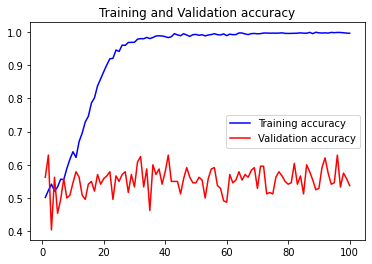

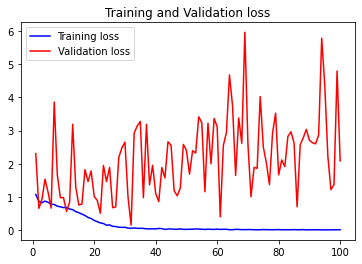

In [57]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [58]:
testGen=generator(X_test,y_test,BATCH_SIZE,ROOT_IMG,mode="eval")

In [59]:
predIdxs = model.predict_generator(testGen,steps=IMG_NUM*TRAIN_RATIO//BATCH_SIZE,verbose=1)

30/30 [==============================] - 31s 1s/step


In [60]:
predIdxs

array([[9.97581720e-01, 2.41829199e-03],
       [1.00000000e+00, 8.73045358e-10],
       [9.66567934e-01, 3.34320553e-02],
       ...,
       [3.23190754e-08, 1.00000000e+00],
       [9.99997616e-01, 2.33189212e-06],
       [1.24714516e-01, 8.75285447e-01]], dtype=float32)

In [63]:
predIdxs_2 = np.argmax(predIdxs, axis=1)

In [64]:
predIdxs_2

array([0, 0, 0, ..., 1, 0, 1])

In [66]:
y_test.values

array([0, 0, 1, ..., 1, 0, 1])

In [67]:
"""
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
"""

'\nscores = model.evaluate(X_test, y_test, verbose=0)\nprint("Accuracy: %.2f%%" % (scores[1]*100))\nprint(\'Test loss:\', scores[0])\nprint(\'Test accuracy:\', scores[1])\n'

,gt,predicted,proba MSI,proba MSS
0,0,0,0.997582,2.418292e-03
1,0,0,1.000000,8.730454e-10
2,1,0,0.966568,3.343206e-02
3,0,1,0.292470,7.075297e-01
4,1,1,0.258632,7.413682e-01


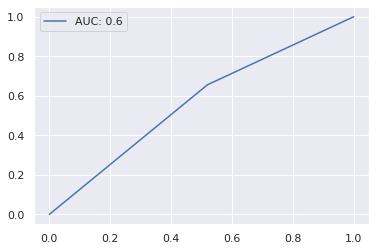

In [91]:
#print(y_score)
roc = roc_curve(y_test.values, predIdxs_2)
display(pd.DataFrame({
    "gt":y_test.values,
    "predicted":predIdxs_2,
    "proba MSI":predIdxs[:,0],
    "proba MSS":predIdxs[:,1]
}).head())

plt.plot(roc[0],roc[1])
plt.legend(["AUC: {}".format(round(roc_auc_score(y_test.values, predIdxs[:,1]),2))])

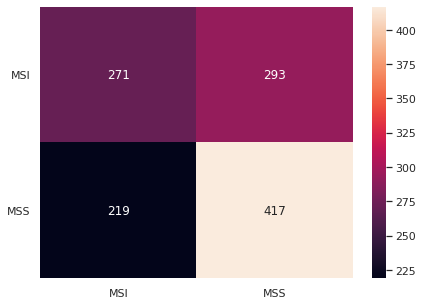

In [106]:
cm = confusion_matrix(y_test.values, predIdxs_2)

# Visualiamos la matriz de confusión
cm_df = pd.DataFrame(cm)  
plt.figure(figsize = (7,5))  
#sn.set(font_scale=1) #for label size  
sn.heatmap(cm_df, annot=True, annot_kws={"size": 12}, fmt="d", xticklabels =["MSI","MSS"], yticklabels=["MSI","MSS"]) # font size  
plt.yticks(rotation=0) 
plt.show() 

In [75]:
cm

array([[271, 293],
       [219, 417]])

In [ ]:
"""
def confusion_matrix(model_dir,weights_dir):
    '''Creates the confusion matrix'''

    #perform a new test
    x_train, x_test, y_train, y_test = train_test_split(np_image_list,image_labels, test_size=0.2, random_state=42)
    # load json and create model
    json_file = open(model_dir, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_dir)
    print("Loaded model from disk")

    Y_pred = loaded_model.predict(x_test)
    Y_true = y_test
    Y_pred = loaded_model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    print(Y_pred_classes)
    Y_true = np.argmax(y_test,axis = 1)
    print(Y_true)
    # compute the confusion matrix
    cm = confusion_matrix(Y_true, Y_pred_classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
"""